In [ ]:
# Import required packages/modules first
import os 
from os.path import join
import sys
from PIL import Image
import numpy as np
import torch
import torchvision
from torchvision import transforms as T
from google.colab.patches import cv2_imshow


# Question 1

Let's first remember Faster R-CNN architecture.

<p align="center">
<img src="https://drive.google.com/uc?export=view&id=1xQ_kJgd_YzWOg9F9w74-uNXR7DdWgqlW" alt="Faster R-CNN" width="700"/>
</p>

<center>
Image source: <a href="http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture11.pdf">Stanford CS231</a>
</center>



* It takes an input image and offers proposals (bounding boxes -BB- for each detection)
* For each proposal it outputs a class, class_score (confidence), regressed BB.



## Part 1
Can you come up an idea to use (only) Faster R-CNN for Multi Object Tracking? Is there any disadvantage of your proposal?


Answer: 

## Part 2

What happens wo NMS before tracking? Why is it important?

Answer:

# Question 2

Let's experiment with Faster R-CNN Network. The code for Faster R-CNN and SORT is taken from [COSE474: Deep Learning @ Korea University](https://github.com/mlvlab/COSE474).

In [ ]:
!gdown --id 1krKnMsNsZRIYSZgnKlN3NdYbJHv-t-aH


Downloading...
From: https://drive.google.com/uc?id=1krKnMsNsZRIYSZgnKlN3NdYbJHv-t-aH
To: /content/mot17_09.zip
114MB [00:00, 276MB/s]


In [ ]:
!unzip mot17_09.zip

In [ ]:
import os 
from os.path import join
root = '/content/'
mot = "content/drive/My Drive/Colab Notebooks/MOT/train/MOT17-09/"
#zip sort files but you are not supposed to use them
#you will download them seperately
MOT_PATH = join(root,mot)


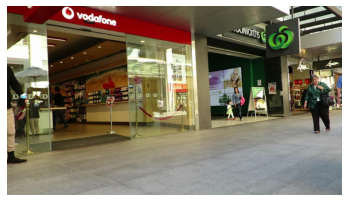

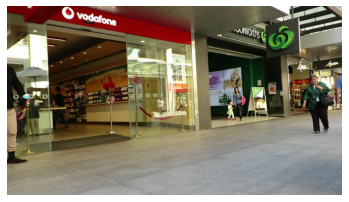

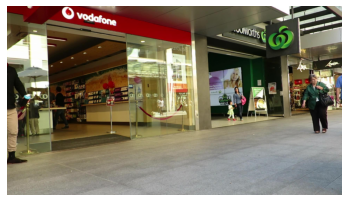

In [ ]:
motdata = join(MOT_PATH,'img1/')
sys.path.append(motdata)


import matplotlib.pylab as plt
import cv2

list_motdata = os.listdir(motdata)  
list_motdata.sort()

# Printing frames before detection
for i in range(3):
  img_ex_path = motdata + list_motdata[i]
  img_ex_origin = cv2.imread(img_ex_path)
  img_ex = cv2.cvtColor(img_ex_origin, cv2.COLOR_BGR2RGB)

  plt.imshow(img_ex)
  plt.axis('off')
  plt.show()

In [ ]:
# Download the pretrained Faster R-CNN model from torchvision

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

In [ ]:
# Class names in MS COCO

COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]


## Part 1 
Here you are expected to write the code for selecting objects with higher softmax scores wrt the given a threshold value. 

*You can assume that the outputs (detections) are already sorted in a decreasing order wrt softmax scores.  Each  output  box  is  associated with  a  category  label,  a  softmax  score  in [0,1], and BB coordinates.*


In [ ]:
# inference with PyTorch

def get_prediction(img_path, threshold):
  img = Image.open(img_path) # Load the image
  transform = T.Compose([T.ToTensor()]) # Defing PyTorch Transform
  img = transform(img) # Apply the transform to the image
  pred = model([img]) # Pass the image to the model
  
  
  #INFERENCE

  pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())] # Get the Prediction Score
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())] # Bounding boxes
  pred_score = list(pred[0]['scores'].detach().numpy())
  
  ##
  # YOUR CODE
  ##

  
  return pred_boxes, pred_class,pred_score

In [ ]:
# Defining a api function for object detection

def object_detection_api(img_path, threshold=0.5, rect_th=3, text_size=1.5, text_th=3, viz=True):
 
  boxes, pred_cls, pred_score = get_prediction(img_path, threshold) # Get predictions
  img = cv2.imread(img_path) # Read image with cv2
  img0 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
  for i in range(len(boxes)):
    cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th) # Draw Rectangle with the coordinates
    cv2.putText(img,pred_cls[i], boxes[i][0],  cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th) # Write the prediction class

  if viz == True:
    
    fig, ax = plt.subplots(1, 2,figsize=(25,500))
    ax[0].imshow(img0) #row=0, col=0
    ax[1].imshow(img) #row=1, col=0
    plt.show()
  return (boxes,pred_cls,pred_score)

Recommended threshold is 0.8, but you may want to experiment with different th values. If you failed the previous question, you will see a high number of detections in your outputs, and will take a long time to finish

In [ ]:
#we will work with first 50 frames 
th=0.8
store=dict()

for i in range(10):
  img_ex_path = motdata + list_motdata[i]
  img_ex_origin = cv2.imread(img_ex_path)

  bb, cls, score = object_detection_api(img_ex_path, threshold=th, viz = True)
  img_name = img_ex_path.split('/')[-1]  
  store[img_name]=[{'bbox':list(sum(bb[i], ())), 'labels':cls[i], 'scores':score[i]} for i in range(len(cls))]
  

In [ ]:
# In store (a dictionary), we store bbox (x1,y1,x2,y2), labels, score (softmax) for each image
store['000001.jpg'][0]

{'bbox': [1698.189, 390.92215, 1864.7689, 729.7769],
 'labels': 'person',
 'scores': 0.99901986}

# Question 3


## Part 1 
Given a distance matrix between previous detections (N) and new detections (N), how many 1-1 matching is possible?

ANSWER

## Part 2

Please compare your answer with the complexity of hungarian algorithm.

ANSWER

**What is a Kalman Filter**

We can use Kalman Filter for tracking objects since it can model the dynamics of moving objects ([Link Coursera](https://www.coursera.org/lecture/state-estimation-localization-self-driving-cars/lesson-1-the-linear-kalman-filter-7DFmY))

    1) Predict: object's future location
    2) Update: the prediction based on new detections


Therefore, it adds a physical bias or intuition to our tracker.



## Part 3
What may happen if you do not use Kalman Filter as the estimation method but your algorithm only considers the new detections? What happens if we use Kalman Filter? (it is open to speculate)

Answer:

## Part 4
You are supposed to implement an algorithm for associating the previous detections with the current ones. Using the BBs from first and second image, create an IoU matrix using BB_1 as tracks and BB_2 new detections. You can use your IoU code from first week.

In [ ]:
# # You can check 'store' variable
store.values()

dict_values([[{'bbox': [1698.189, 390.92215, 1864.7689, 729.7769], 'labels': 'person', 'scores': 0.99901986}, {'bbox': [1289.7858, 463.80878, 1359.0836, 658.78217], 'labels': 'person', 'scores': 0.99520594}, {'bbox': [1254.3234, 536.06964, 1313.8627, 654.61945], 'labels': 'person', 'scores': 0.9948597}, {'bbox': [0.0, 327.20285, 113.80242, 911.40314], 'labels': 'person', 'scores': 0.9948173}, {'bbox': [251.4367, 451.7073, 352.60736, 714.4502], 'labels': 'person', 'scores': 0.9794332}, {'bbox': [861.0734, 512.28284, 904.42084, 628.4965], 'labels': 'person', 'scores': 0.94857}, {'bbox': [1881.9286, 389.66904, 1920.0, 579.73914], 'labels': 'person', 'scores': 0.9336577}, {'bbox': [44.553722, 347.3725, 239.73283, 488.53528], 'labels': 'umbrella', 'scores': 0.92146164}, {'bbox': [115.42345, 506.15353, 200.89316, 742.7139], 'labels': 'person', 'scores': 0.85744303}, {'bbox': [1777.9829, 463.4575, 1883.7495, 578.90173], 'labels': 'handbag', 'scores': 0.8495527}], [{'bbox': [1691.0531, 388.220

In [ ]:
#select BBs from first two frames
bb1 = [i['bbox'] for i in list(store.values())[0]]
bb2 = [i['bbox'] for i in list(store.values())[1]]

In [ ]:
#code from first week's notebook
# code taken from: https://gist.github.com/meyerjo/dd3533edc97c81258898f60d8978eddc

def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = abs(max((xB - xA, 0)) * max((yB - yA), 0))
    if interArea == 0:
        return 0
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = abs((boxA[2] - boxA[0]) * (boxA[3] - boxA[1]))
    boxBArea = abs((boxB[2] - boxB[0]) * (boxB[3] - boxB[1]))

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou

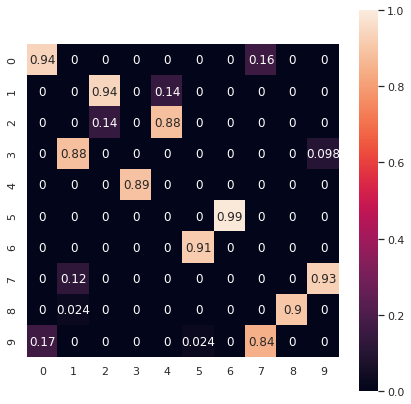

In [ ]:
# calculate  IoU for each combination to fill the matrix M
# horizontal new detections
# vertical past detections as tracks
# Visualize the matrix

M = np.zeros((len(bb1), len(bb2)))


#ANSWER
#Here

import seaborn as sns; sns.set_theme()

f, ax = plt.subplots(figsize=(7, 7))
ax = sns.heatmap(M, annot=True, vmin=0,vmax=1,square=True)


## Part 5 

Write a minimal association function for matching past tracks with new detections given the IoU matrix. We do not have unmatched detections (IoU threshold) in this example. And, it is okay to do matching in the given order (first track is matched, second tract is matched, ..., Nth track is matched.) 

You can use `%%time` to see your code's execution time.

In [ ]:
#you are now supposed to find the corresponded tracks (y axis) matches for each new track (x axis)

def minimal_association(M):
  #your code here
  #answer
  
  return(inds)

In [ ]:
%%time
minimal_association(M)

CPU times: user 906 µs, sys: 0 ns, total: 906 µs
Wall time: 751 µs


array([0., 2., 4., 1., 3., 6., 5., 9., 8., 7.])

Now install munkres library to see the performance of Munkres (Hungarian algorithm). Munkres optimizes for minimum cost, so you need to adapt your Matrix M of IoU accordingly.

In [ ]:
!pip install munkres

In [ ]:
from munkres import Munkres

m = Munkres()

#Answer



In [ ]:
%%time
indexes = m.compute(M_n)

CPU times: user 379 µs, sys: 0 ns, total: 379 µs
Wall time: 386 µs


## Part 6 
Which metrics can be used instead of IoU for association step? 

Answer: Appearance + L2

## Part 7

Use Simple Online and Realtime Tracking (SORT) Algorithm

Source: [SORT Github](https://github.com/abewley/sort/)

"SORT is an online tracking algorithm which only uses past and current frames. Please note that accuracy of the SORT hugely depends on the detections. It is designed for online tracking applications where only past and current frames are available and the method produces object identities on the fly. While this minimalistic tracker doesn't handle occlusion or re-entering objects its purpose is to serve as a baseline and testbed for the development of future trackers.

SORT algorithm basically uses

* Kalman Filter as the estimation model.
* Hungarian Algorithm for data association a.k.a. matching estimations with ongoing tracks.
* IOU thresholding the unmatched detections for creating a new track identity. 
* T_lost counting for deleting the identity. (When an object is not matched for t frames it is deleted.)"

In [ ]:
#SORT 
# Git clone: SORT Algorithm (to the same path that you defined at the beginning.)

!cd "{root}";git clone https://github.com/abewley/sort.git
sort = join(root,'sort/')
sys.path.append(sort)

Cloning into 'sort'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 202 (delta 0), reused 1 (delta 0), pack-reused 198
Receiving objects: 100% (202/202), 1.21 MiB | 1.37 MiB/s, done.
Resolving deltas: 100% (69/69), done.


In [ ]:
!cd "{sort}";pip install -r requirements.txt

     |████████████████████████████████| 184kB 5.4MB/s 
     |████████████████████████████████| 12.4MB 6.0MB/s 
     |████████████████████████████████| 1.5MB 52.7MB/s 
  Created wheel for filterpy: filename=filterpy-1.4.5-cp36-none-any.whl size=110453 sha256=6bc4adfa058d709a6031fe47c245220f114724d1f7ade5e93f7a63b52a6e96e5
  Stored in directory: /root/.cache/pip/wheels/c3/0c/dd/e92392c3f38a41371602d99fc77d6c1d42aadbf0c6afccdd02
  Created wheel for lap: filename=lap-0.4.0-cp36-cp36m-linux_x86_64.whl size=1589039 sha256=04d480fa139ed6b0f139fba48a9bcd86ace1aac8a98ae54e0920dbb799991ca9
  Stored in directory: /root/.cache/pip/wheels/da/3e/af/eddcd6ffaa27df8d0ddac573758f8953c4e57c64c4c8c8b7d0
Successfully built filterpy lap
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scikit-image 0.16.2
    Uninstalling scikit-image-0.16.2:
      Successfully uninstalled scikit-image-0.16.2


In [ ]:
import skimage
print(skimage.__version__)

0.17.2


In [ ]:
img_path = motdata    # img root path
# Making new directory for saving results
save_path = join('/content/','save_your_results/')
!mkdir "{save_path}"
#results in content/sort/save

In [ ]:
#if error run again
import matplotlib
matplotlib.use('TKAgg')


In [ ]:
import json
import collections
from pprint import pprint
from sort import *
np.set_printoptions(suppress=True)

mot_tracker = Sort()      # Tracker using SORT Algorithm

In [ ]:
#here we use our detections by Faster R CNN for tracking
#inputing them to SORT

store2 = collections.OrderedDict(sorted(store.items()))
bbs_ids=dict()
for key in store2.keys():   
    arrlist = []
    det_img = cv2.imread(os.path.join(img_path, key))
    overlay = det_img.copy()
    det_result = store2[key] 
    
    for info in det_result:
        bbox = info['bbox']
        labels = info['labels']
        scores = info['scores']
        templist = bbox+[scores]
        
        if labels == 'person': # label 1 is a person in MS COCO Dataset
            arrlist.append(templist)
            
    track_bbs_ids = mot_tracker.update(np.array(arrlist))
    bbs_ids[int(key.split('.')[0])]=np.float32(track_bbs_ids)

    mot_imgid = key.replace('.jpg','')
    newname = save_path + mot_imgid + '_mot.jpg'
    print(mot_imgid)
    
    for j in range(track_bbs_ids.shape[0]):  
        ele = track_bbs_ids[j, :]
        x = int(ele[0])
        y = int(ele[1])
        x2 = int(ele[2])
        y2 = int(ele[3])
        track_label = str(int(ele[4])) 
        cv2.rectangle(det_img, (x, y), (x2, y2), (0, 255, 255), 4)
        cv2.putText(det_img, '#'+track_label, (x+5, y-10), 0,0.6,(0,255,255),thickness=2)
        
    cv2.imwrite(newname,det_img)

    cv2_imshow(cv2.resize(det_img, (960, 540)))

In [ ]:
# edit bbs_ids with the shape 
# {image name: object id, x1, y1, w, h}
# remember current format is x1,y1,x2,y2

sort_id_bbs =bbs_ids.copy()
for k in bbs_ids.keys():
  sort_id_bbs[k]= sort_id_bbs[k][:, [4, 0, 1, 2, 3]]
  sort_id_bbs[k][:,3:5]=sort_id_bbs[k][:,3:5]-sort_id_bbs[k][:,1:3]

In [ ]:
# #check new format if you want
sort_id_bbs[1]

array([[   8.       ,  115.42345  ,  506.15353  ,   85.46971  ,
         236.5604   ],
       [   7.       , 1881.9286   ,  389.66904  ,   38.07141  ,
         190.0701   ],
       [   6.       ,  861.0734   ,  512.28284  ,   43.347412 ,
         116.213684 ],
       [   5.       ,  251.4367   ,  451.7073   ,  101.170654 ,
         262.7429   ],
       [   4.       ,   -0.0000014,  327.20285  ,  113.80242  ,
         584.2003   ],
       [   3.       , 1254.3234   ,  536.06964  ,   59.539307 ,
         118.549805 ],
       [   2.       , 1289.7858   ,  463.80878  ,   69.29785  ,
         194.97339  ],
       [   1.       , 1698.189    ,  390.92215  ,  166.57996  ,
         338.85477  ]], dtype=float32)

Now, we first visualize the gt BBs and tracks. MOT17 dataset is described as follows. (MOT16 and 17 have same format)

<p align="center">
<img src="https://drive.google.com/uc?export=view&id=1uqHXqacyNs2IK8RGoUAKNzQc_UqQezDL" alt="Table5" width="650"/>
<img src="https://drive.google.com/uc?export=view&id=1sAU6xOKlgrJcvliALycaMjM2MQwvgDdk" alt="Table6" width="330"/>
</p>

<center>
Image source: <a href="https://arxiv.org/pdf/1603.00831.pdf">MOT16: A Benchmark for Multi-Object Tracking</a>
</center>

In [ ]:
gt_s = np.intc(np.loadtxt(MOT_PATH+'/gt/gt.txt',dtype=np.float64, delimiter=','))


In [ ]:
#this function is used for reading gt id and bbs from MOT17-09
def bbx(X, imgN=1):

  mask = (X[:, 0] ==imgN ) & (X[:, -3] ==1) #class 7 (-3) which flags the considered ==1
  X = X[mask] #frm_id,seq_id,xmin,ymin,w,h,confidence,class,visibility
  bbs = X[:, 1:6] #seq_id,xmin,ymin,w,h
  
  return np.intc(bbs)


In [ ]:
#shows gt tracks in image 00002
bbx(gt_s,imgN = 2)

array([[   1,  262,  449,  102,  263],
       [  19, 1685,  386,  170,  347],
       [  20, 1883,  326,  157,  406],
       [  21, 1256,  534,   62,  127],
       [  22, 1293,  458,   71,  203],
       [  23, -340,  234,  473,  695]], dtype=int32)

In [ ]:
def print_gt(gt_s, img_N,img_path):
  img_path = img_path+str(img_N).zfill(6)+'.jpg'  
  img = cv2.imread(img_path) # Read image with cv2
  img0 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  K = bbx(gt_s,img_N)


  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
  for i in range(K.shape[0]):
    cv2.rectangle(img, (K[i][1], K[i][2]), (K[i][1]+K[i][3], K[i][2]+ K[i][4]), color=(0, 255, 0), thickness=10) # Draw Rectangle with the coordinates
    cv2.putText(img, str(K[i][0]), (K[i][1], K[i][2]),  cv2.FONT_HERSHEY_SIMPLEX, 1, color=(0,255,0),thickness=2) # Write the prediction clas



  fig, ax = plt.subplots(1, 2,figsize=(50,500))
  ax[0].imshow(img0) #row=0, col=0
  ax[1].imshow(img) #row=1, col=0
  plt.show()

In [ ]:
p=MOT_PATH+'img1/'
for i in range(10):
  print_gt(gt_s,i+1,p)


## Part 8

o_k denote from ground truths, h_k denote tracking results. You can see that mismatches can occur when there are occlusions.

<p align="center">
<img src="https://drive.google.com/uc?export=view&id=1KHYeG0-PZz3a9Eah4p4sGEWuPTwtIs-a" alt="Fast R-CNN" width="900"/>
</p>

<center>
Tracking visualization.
</center>

<p align="center">
<img src="https://drive.google.com/uc?export=view&id=1O5jFYCm3H0vDZOMq-yLQ8LFmSENJxHjU" alt="Fast R-CNN" width="350"/>
</p>

<center>
MOTA 
</center>
source: <a href="https://www.researchgate.net/publication/26523191_Evaluating_multiple_object_tracking_performance_The_CLEAR_MOT_metrics">Bernardin, Keni, and Rainer Stiefelhagen. "Evaluating multiple object tracking performance: the CLEAR MOT metrics." EURASIP Journal on Image and Video Processing 2008.1 (2008): 1-10</a>


In [ ]:
!pip install motmetrics

     |████████████████████████████████| 153kB 5.3MB/s 
     |████████████████████████████████| 81kB 4.5MB/s 
     |████████████████████████████████| 51kB 4.1MB/s 
     |████████████████████████████████| 51kB 4.4MB/s 
     |████████████████████████████████| 71kB 4.8MB/s 
     |████████████████████████████████| 102kB 5.1MB/s 
  Created wheel for py-cpuinfo: filename=py_cpuinfo-7.0.0-cp36-none-any.whl size=20072 sha256=2b6f4ecf6d11b185905bb9ca7912c82e27488a36a620b9a5a4a06b96c7df1a03
  Stored in directory: /root/.cache/pip/wheels/f1/93/7b/127daf0c3a5a49feb2fecd468d508067c733fba5192f726ad1
Successfully built py-cpuinfo
ERROR: pytest-benchmark 3.2.3 has requirement pytest>=3.8, but you'll have pytest 3.6.4 which is incompatible.


In [ ]:
import motmetrics as mm
# List all default metrics
mh = mm.metrics.create()
print(mh.list_metrics_markdown())

Name|Description
:---|:---
num_frames|Total number of frames.
obj_frequencies|Total number of occurrences of individual objects over all frames.
pred_frequencies|Total number of occurrences of individual predictions over all frames.
num_matches|Total number matches.
num_switches|Total number of track switches.
num_transfer|Total number of track transfer.
num_ascend|Total number of track ascend.
num_migrate|Total number of track migrate.
num_false_positives|Total number of false positives (false-alarms).
num_misses|Total number of misses.
num_detections|Total number of detected objects including matches and switches.
num_objects|Total number of unique object appearances over all frames.
num_predictions|Total number of unique prediction appearances over all frames.
num_unique_objects|Total number of unique object ids encountered.
track_ratios|Ratio of assigned to total appearance count per unique object id.
mostly_tracked|Number of objects tracked for at least 80 percent of lifespan.
par

In [ ]:
#example from https://github.com/cheind/py-motmetrics
#iou_matrix gives 1-IoU, since it solves the minimal cost association
a = np.array([
    [0, 0, 1, 2],    # Format X, Y, Width, Height
    [0, 0, 0.8, 1.5],
])

b = np.array([
    [0, 0, 1, 2],
    [0, 0, 1, 1],
    [0.1, 0.2, 2, 2],
])
mm.distances.iou_matrix(a, b)

array([[0.        , 0.5       , 0.63013699],
       [0.4       , 0.42857143, 0.78787879]])

In [ ]:
#printing sequence ids in image 00001
bbx(gt_s,imgN=1)[:,0]

array([ 1, 19, 20, 21, 22, 23], dtype=int32)

In [ ]:
#remember formats
print(bbx(gt_s,imgN=1)[:,0:])
print(sort_id_bbs[1])

[[   1  260  450  102  262]
 [  19 1686  387  171  345]
 [  20 1886  327  156  404]
 [  21 1253  533   63  129]
 [  22 1292  459   70  202]
 [  23 -348  235  477  695]]
[[   8.         115.42345    506.15353     85.46971    236.5604   ]
 [   7.        1881.9286     389.66904     38.07141    190.0701   ]
 [   6.         861.0734     512.28284     43.347412   116.213684 ]
 [   5.         251.4367     451.7073     101.170654   262.7429   ]
 [   4.          -0.0000014  327.20285    113.80242    584.2003   ]
 [   3.        1254.3234     536.06964     59.539307   118.549805 ]
 [   2.        1289.7858     463.80878     69.29785    194.97339  ]
 [   1.        1698.189      390.92215    166.57996    338.85477  ]]


In [ ]:
#calculate IoU given bbx and sort_id_bbs
#remember 
#bbx(gt_s,imgN=1) #seq_id,xmin,ymin,w,h
#sort_id_bbs[1] #seq_id,xmin,ymin,w,h

N=1 #given image number
#answer:

print(ans)

[[0.         0.         0.         0.82549032 0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.87321155]
 [0.         0.10129468 0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.86850907
  0.17977707 0.        ]
 [0.         0.         0.         0.         0.         0.1392958
  0.8975964  0.        ]
 [0.00921513 0.         0.         0.         0.2005442  0.
  0.         0.        ]]


## Part 9
Create an accumulator that will be updated during each frame. adn calculate MOTA

In [ ]:
# Create an accumulator that will be updated during each frame
acc = mm.MOTAccumulator(auto_id=True)

# Call update once for per frame. For now, assume distances between
# frame objects / hypotheses are given.

def acc_update(acc,N):

  gt_id_bbx = bbx(gt_s,imgN=N)
  gt_id, gt_bbx = gt_id_bbx[:,0:1],gt_id_bbx[:,1:5]

  pred_id_bbx = sort_id_bbs[N]
  sort_id, sort_bbx = pred_id_bbx[:,0:1],pred_id_bbx[:,1:]
  ans = 1-mm.distances.iou_matrix(a, b)

  acc.update(
      list(gt_id[:,0]),                     # Ground truth objects in this frame
      list(sort_id[:,0]),                  # Detector hypotheses in this frame
      mm.distances.iou_matrix(gt_bbx, sort_bbx)
  )


  return acc



In [ ]:
#empty
print(acc.mot_events)

Empty DataFrame
Columns: [Type, OId, HId, D]
Index: []


In [ ]:
#for first 1...T images compute MOTA
acc = mm.MOTAccumulator(auto_id=True)
for i in range(10):
  acc = acc_update(acc,i+1)

In [ ]:
print(acc.mot_events)

                Type   OId  HId         D
FrameId Event                            
0       49     MATCH   1.0  5.0  0.174510
        50     MATCH  19.0  1.0  0.126788
        51     MATCH  20.0  7.0  0.898705
        52     MATCH  21.0  3.0  0.131491
        53     MATCH  22.0  2.0  0.102404
...              ...   ...  ...       ...
9       52     MATCH  19.0  1.0  0.136065
        53     MATCH  20.0  7.0  0.831522
        54     MATCH  21.0  3.0  0.270961
        55     MATCH  22.0  2.0  0.131522
        56     MATCH  23.0  4.0  0.620301

[78 rows x 4 columns]


In [ ]:
mh = mm.metrics.create()
summary = mh.compute(acc, metrics=['num_frames', 'mota', 'motp'], name='acc')
print(summary)


     num_frames      mota      motp
acc          10  0.741935  0.400939


# Question 4


## Part1
Person re-identification is an important concept in MOT for two reasons. In some settings, we may have multiple cameras that record same area from different points. Therefore we may want to associate the people (or any object that we track) recorded by different cameras. It can also be used to given same id to a person leaves the setting and re-enters in future. 

<p align="center">
<img src="
https://robustsystems.coe.neu.edu/sites/robustsystems.coe.neu.edu/files/systems/projectpages/img/reid_dataset/eg_prw.png"  width="700"/>
</p>
<center>
Image source: <a href="https://arxiv.org/pdf/1604.02531.pdf">Person Re-identification in the Wild</a>
</center>


How would you approach to re-identification problem? Would you use a classifier or a regressor?

Should a re-idendification model be retrained when a new identity appears in the system? Is it sustainable?

Answer :

## Part 2

**TripletLoss**

Source:[TensorFlow Addons Losses: TripletSemiHardLoss](https://github.com/tensorflow/addons/blob/master/docs/tutorials/losses_triplet.ipynb)

"As first introduced in the [FaceNet paper](https://arxiv.org/pdf/1503.03832.pdf), TripletLoss is a loss function that trains a neural network to closely embed features of the same class while maximizing the distance between embeddings of different classes.  To do this an anchor  is chosen along with one negative and one positive sample."
<p align="center">
<img src="https://user-images.githubusercontent.com/18154355/61485418-1cbb1f00-a96f-11e9-8de8-3c46eef5a7dc.png"  width="700"/>
</p>


**The loss function is described as a Euclidean distance function:**

<p align="center">
<img src="https://user-images.githubusercontent.com/18154355/61484709-7589b800-a96d-11e9-9c3c-e880514af4b7.png" width="700"/>
</p>



"Where A is our anchor input,  P is the positive sample input,  N is the negative sample input, and alpha is some margin you use to specify when a triplet has become too "easy" and you no longer want to adjust the weights from it."

**SemiHard Online Learning**

Source:[TensorFlow Addons Losses: TripletSemiHardLoss](https://github.com/tensorflow/addons/blob/master/docs/tutorials/losses_triplet.ipynb)

"As shown in the paper, the best results are from triplets known as "Semi-Hard". These are defined as triplets where the negative is farther from the anchor than the positive, but still produces a positive loss. To efficiently find these triplets you utilize online learning and only train from the Semi-Hard examples in each batch."

<p align="center">
<img src="https://omoindrot.github.io/assets/triplet_loss/triplets.png" alt="Fast R-CNN" width="550"/>
</p>

<center>
Image source: <a href="https://omoindrot.github.io/triplet-loss">omoindrot.github.io</a>
</center>



Below you have a code snippet from Tensorflow which shows how to use TripletSemiHardLoss() for creating embeddings with triplet loss.

In [ ]:
#adapted from https://github.com/tensorflow/addons/blob/master/docs/tutorials/losses_triplet.ipynb

#Please use the GPU for this part.
#you can check with
#tf.config.experimental.list_physical_devices('GPU')


import io
import numpy as np

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds

In [ ]:
def _normalize_img(img, label):
    img = tf.cast(img, tf.float32) / 255.
    return (img, label)

train_dataset, test_dataset = tfds.load(name="mnist", split=['train', 'test'], as_supervised=True)

# Build your input pipelines
train_dataset = train_dataset.shuffle(1024).batch(32)
train_dataset = train_dataset.map(_normalize_img)

test_dataset = test_dataset.batch(32)
test_dataset = test_dataset.map(_normalize_img)


test_labels = np.concatenate([i[1] for i in list(test_dataset.as_numpy_iterator())])
test_data = np.concatenate([i[0] for i in list(test_dataset.as_numpy_iterator())])

Build the Model

![fig2](https://user-images.githubusercontent.com/18154355/61485417-1cbb1f00-a96f-11e9-8d6a-94964ce8c4db.png)

In [ ]:
#you can experiment with different filter numbers

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'), 
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128, activation=None), # No activation on final dense layer
    tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings

])

Train and Evaluate

In [ ]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tfa.losses.TripletSemiHardLoss())


In [ ]:
#store embedding before training the network
x_embeddings_before_train = model.predict(test_dataset)

In [ ]:
# Train the network
epochs=10
history = model.fit(
    train_dataset,
    epochs=epochs)

Epoch 1/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.4006
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1031
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0784
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0661
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0567
Epoch 6/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0534
Epoch 7/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0504
Epoch 8/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0445
Epoch 9/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0438
Epoch 10/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0389


In [ ]:
# Inference, output the embeddings after network is trained
x_embeddings = model.predict(test_dataset)

In [ ]:
#create 256 dim embeddings for each test point
print(x_embeddings.shape,x_embeddings_before_train.shape)

(10000, 128) (10000, 128)


In [ ]:
# code adapted from https://github.com/AdrianUng/keras-triplet-loss-mnist/

plt.style.use('fivethirtyeight')
test_class_labels = np.unique(np.array(test_labels))


# for visualizing initial and trained embeddings
import matplotlib.pyplot as plt, numpy as np
from sklearn.decomposition import PCA


no_of_components=2
pca = PCA(n_components=no_of_components)
decomposed_embeddings = pca.fit_transform(x_embeddings)
decomposed_embeddings_before_train = pca.transform(x_embeddings_before_train)
step=100


fig = plt.figure(figsize=(8, 8))
for label in test_class_labels:
    decomposed_embeddings_before_train_class = decomposed_embeddings_before_train[test_labels == label]
    plt.scatter(decomposed_embeddings_before_train_class[::step,1], decomposed_embeddings_before_train_class[::step,0],label=str(label))
    plt.title('before training')
    plt.legend()
plt.show()

fig = plt.figure(figsize=(8, 8))
for label in test_class_labels:
    decomposed_embeddings_class = decomposed_embeddings[test_labels == label]
    plt.scatter(decomposed_embeddings_class[::step, 1], decomposed_embeddings_class[::step, 0], label=str(label))
    plt.title('after @%d epochs' % epochs)
    plt.legend()

plt.show()

Building the bridge with MOT:

If we have a model that provides us the embeddings, we can use it for comparing a new object with the previous ones by considering the similarity between them. This can help us solving the re-identification problem.

# Question 5

In the last part, we will consider some graph notation for MOT. 

## Part 1

<p align="center">
<img src="https://drive.google.com/uc?export=view&id=1_9A3zNV4cM1Da_jhMH9aykUArmo0KyXd" alt="Faster R-CNN" width="700"/>
</p>
<center>
Image: Objective Function in Network Flow Formulization</a>
</center>



Assume that we will associate the nodes by using minimum cost flow problem, which metrics may be suitable for calculating edge scores?

answer: 

## Part 2

What happens to our graph when all the cost are positive? (trivial solution)

asnwer: 

## Part 3

In order to overcome this trivial solution we need to have negative costs. Please implement and plot log odds ratio (LOR).

$$
LOR(p)= \log \left(\frac{p}{1-p}\right)
$$

In [ ]:
#use log odds ratio for changing the cost to negative ones
#it is a two line code you can implement it with numpy.
#visualize it with plt.plot
#answer:


## Part 4

Consider the complete graph (you can disregard source and sink costs for this question)
<p align="center">
<img src="https://drive.google.com/uc?export=view&id=12SPUqab34SBxnj63SPn_mSrBzA11GBBN" alt="Faster R-CNN" width="700"/>
</p>


<center>
Image and equation source: <a href="https://ieeexplore.ieee.org/document/4587584?arnumber=4587584">Global Data Association for Multi-Object Tracking Using Network Flows</a>
</center>

Given the cost function with **only blue edges**
$$
Cost =\underset{\mathcal{T}}{\operatorname{argmin}} \sum_{i, j} C_{i, j} f_{i, j}
$$

How do we update the objective function when we introduce red edges?

Answer: 

How do red and blue edges differ in terms of tracking and including a detection in the graph?

Answer: 